# TME 7 - Approches par modèles de substitution

Réalisé par :

* BENHADDAD Sabrina
* BENSIDHOUM Azzedine



In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import _tree
from sklearn.metrics import accuracy_score

import pydotplus
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Exercice 1 - Construction de règles contre-factuelles

L'objectif de cet exercice est de générer des règles contrefactuelles suite à une classification avec un arbre de décision

### 1. Génération des données et construction des bases d'apprentissage et de test

Pour cet exercice, nous avons choisi d'opter pour le dataset *iris* et d'utiliser l'algorithme de sklearn.  

In [2]:
#On commence par load le dataset
iris = load_iris()
#print(iris)
#On crée un dataframe pour voir ce que contient le dataset
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
#Séparer en base de test et d'apprentissage
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.2)

In [4]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


### 2. Construction de l'arbre de décision

À l'aide de l'algorithme de sklearn

In [5]:
#Construction de l'arbre de décision
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [6]:
print(f"Accuracy score : {accuracy_score(y_test,dt.predict(X_test))*100} %")


Accuracy score : 93.33333333333333 %


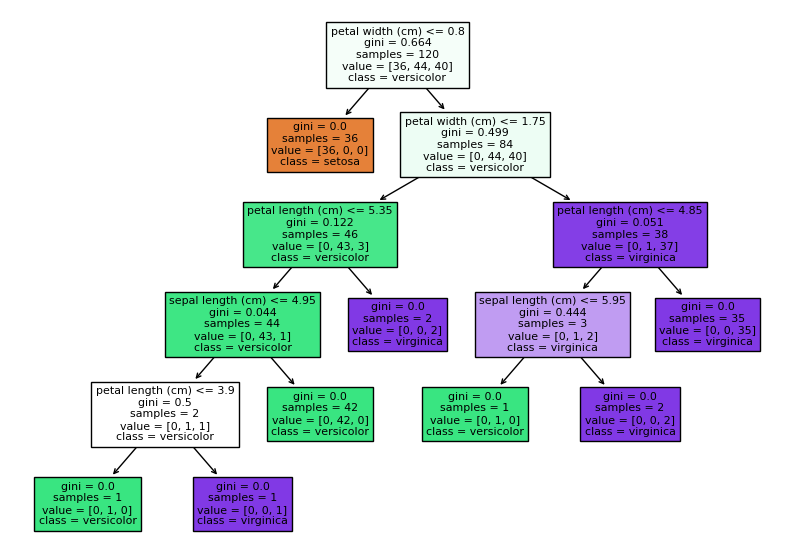

In [7]:
fig = plt.figure(figsize = (10,7))
tree.plot_tree(dt, feature_names=iris.feature_names, class_names = iris.target_names, filled = True)
plt.show()

Cette figure, représente l'arbre de décision construit grâce à l'algorithme de sklearn

### 3. Classement de l'exemple de référence x et affichage des règles activées pour son classement

In [8]:
#Choix random de l'exemple de référence
i = 15
x = X_test[i]

y_hat = dt.predict(x.reshape(1,-1))
print(y_hat)

[0]


In [9]:
print(x)

[5.7 3.8 1.7 0.3]


Tentons à présent d'expliquer la classification de l'exemple de référence ; autrement dit, nous allons afficher les règles activées pour son classement

In [10]:
# Solution n°1 :
dt.decision_path(x.reshape(1,-1)).todense()

matrix([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
chemin_decision = dt.decision_path(x.reshape(1,-1))

Commentaire :

Cette solution indique les noeuds où passe l'exemple d'observation

In [12]:
# Solution 2 : Retourne the text representation of the rules
from sklearn.tree import export_text
tree_rules = export_text(dt, feature_names = iris.feature_names)
print(tree_rules)

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 5.35
|   |   |   |--- sepal length (cm) <= 4.95
|   |   |   |   |--- petal length (cm) <= 3.90
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal length (cm) >  3.90
|   |   |   |   |   |--- class: 2
|   |   |   |--- sepal length (cm) >  4.95
|   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  5.35
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal length (cm) <= 5.95
|   |   |   |   |--- class: 1
|   |   |   |--- sepal length (cm) >  5.95
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



Cette solution affiche quant à elle, les règles qui ont servi à la classification de nos exemples au sein de l'arbre de décision construit.

Ce qui rejoint par ailleurs, les résultats obtenus plus haut.


In [13]:
# Solution 3 : extraction des règles et affichage pour l'exemple d'observation

In [14]:
chemin_decision

<1x15 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [15]:
def expl(X_test,i):
  leaf_id = dt.apply(X_test)
  threshold = dt.tree_.threshold
  feature = dt.tree_.feature

  # Assuming chemin_decision is a sparse matrix, this extracts the indices for the i-th row
  node_index = chemin_decision.indices[chemin_decision.indptr[0] : chemin_decision.indptr[1]]

  print("Rules used to predict sample {id}:\n".format(id=i))
  for node_id in node_index:
      # Continue to the next node if it is a leaf node
      if leaf_id[i] == node_id:
          continue

      # Check if the value of the split feature for the sample is below the threshold
      if X_test[i, feature[node_id]] <= threshold[node_id]:
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print(
          "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=i,
              feature=feature[node_id],
              value=X_test[i, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id],
          )
      )


In [16]:
expl(X_test,i)

Rules used to predict sample 15:

decision node 0 : (X_test[15, 3] = 0.3) <= 0.800000011920929)


### 4. Afficher toutes les règles contre-factuelles r' et nombre de tests invalidés

In [17]:
def nodes_seen(decision_path, tree_clf, class_names):
    nodes_visited = []

    # Parcours du chemin de décision
    for sample_path in decision_path:
        # Récupération des indices des nœuds non nuls dans le chemin
        node_indices = sample_path.indices

        # Ajout des nœuds visités à la liste
        nodes_visited.extend(node_indices)

    # Suppression des doublons pour obtenir une liste unique
    nodes_visited = list(set(nodes_visited))

    #avoir le nom de classe
    val_tree = tree_clf.tree_
    classes = val_tree.value[nodes_visited[-1]]
    l = np.argmax(classes)
    print("class : ",class_names[l])
    return nodes_visited,class_names[l]

# Exemple d'utilisation avec un modèle d'arbre de décision et X_test
nodes_visited = nodes_seen(chemin_decision, dt, iris.target_names)

print(f"Liste des nœuds visités par l'arbre pour l'exemple {i} : {nodes_visited}")


class :  setosa
Liste des nœuds visités par l'arbre pour l'exemple 15 : ([0, 1], 'setosa')


In [18]:
def cf_rules(tree, feature_names, class_names,nodes_visited):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name,node} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name,node} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:

            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
    recurse(0, path, paths)

    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    rules = []
    for path in paths:
        rule = "if "
        for p in path[:-1]:

            classes = path[-1][0][0]
            l = np.argmax(classes)
            class_i = class_names[l]

            if(nodes_visited[-1]!=class_i):
              #node id
              node_id = int(p.split(',')[1][1])
              if rule != "if ":
                  rule += " and "
              rule += str(p)
        # Prendre seulement les regles contre-factuels
        if(nodes_visited[-1]!=class_i):
          rule += " then "
          rule += f"class: {class_i} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
          rules += [rule]
    return rules , len(rules)

In [19]:
cf_r, nr = cf_rules(dt, iris.feature_names, iris.target_names, nodes_visited)

print(f"Règles contrefactuelles r' : ")
for r in cf_r :
  print(r)

print(f"Nombre de tests invalidés pour l'exemple d'observation {i}, {x} est : {nr}")


Règles contrefactuelles r' : 
if (('petal width (cm)', 0) > 0.8) and (('petal width (cm)', 2) <= 1.75) and (('petal length (cm)', 3) <= 5.35) and (('sepal length (cm)', 4) > 4.95) then class: versicolor (proba: 100.0%)
if (('petal width (cm)', 0) > 0.8) and (('petal width (cm)', 2) > 1.75) and (('petal length (cm)', 10) > 4.85) then class: virginica (proba: 100.0%)
if (('petal width (cm)', 0) > 0.8) and (('petal width (cm)', 2) > 1.75) and (('petal length (cm)', 10) <= 4.85) and (('sepal length (cm)', 11) > 5.95) then class: virginica (proba: 100.0%)
if (('petal width (cm)', 0) > 0.8) and (('petal width (cm)', 2) <= 1.75) and (('petal length (cm)', 3) > 5.35) then class: virginica (proba: 100.0%)
if (('petal width (cm)', 0) > 0.8) and (('petal width (cm)', 2) > 1.75) and (('petal length (cm)', 10) <= 4.85) and (('sepal length (cm)', 11) <= 5.95) then class: versicolor (proba: 100.0%)
if (('petal width (cm)', 0) > 0.8) and (('petal width (cm)', 2) <= 1.75) and (('petal length (cm)', 3) 

### 5. Explication pour classification de x par l'arbre de décision

L'exemple de référence est classé **Virginica**.

Il n'est pas de type **setosa** car :      
* La largeur de ses pétales est de 2.3, elle est donc supérieure à 0.8

Ainsi, si la largeur de ses pétales était inférieure à 0.8, l'exemple serait classé setosa.

Il n'est pas de type **versicolor** car :       
* la largeur de ses pétales est supérieure à 1.75
* la longueur de ses pétales est supérieure à 4.9

L'exemple serait classé versicolor s'il avait :
* petal length <= 4.9 et sepal width > 3.1

ou


* 0.8 < largeur pétale <= 1.75 et  :   

* * petal length <= 5.35 et sepal length > 4.95 et sepal width > 2.25
* * petal length <= 4.75 et sepal length > 4.95 et sepal width >= 2.25
* * petal length <= 3.9 et sepal length <= 4.95

### 6. Méthode explication pour l'utilisateur

Pour ce faire, nous proposons cette approche qui consiste à afficher le chemin effectué pour classifier l'exemple x

In [20]:
def plot_path(decision_paths,idx,clf,feature_names=iris.feature_names,class_names=iris.target_names):
  dot_data = tree.export_graphviz(clf, out_file=None,
                                  feature_names=feature_names,
                                  class_names=class_names,
                                  filled=True, rounded=True,
                                  special_characters=True)
  graph = pydotplus.graph_from_dot_data(dot_data)

  # empty all nodes, i.e.set color to white and number of samples to zero
  for node in graph.get_node_list():
      if node.get_attributes().get('label') is None:
          continue
      if 'samples = ' in node.get_attributes()['label']:
          labels = node.get_attributes()['label'].split('<br/>')
          for i, label in enumerate(labels):
              if label.startswith('samples = '):
                  labels[i] = 'samples = 0'
          node.set('label', '<br/>'.join(labels))
          node.set_fillcolor('white')

  for decision_path in decision_paths:
      for n, node_value in enumerate(decision_path.toarray()[0]):
          if node_value == 0:
              continue
          node = graph.get_node(str(n))[0]
          node.set_fillcolor('red')
          labels = node.get_attributes()['label'].split('<br/>')
          for i, label in enumerate(labels):
              if label.startswith('samples = '):
                  labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

          node.set('label', '<br/>'.join(labels))

  filename = 'sapmle_tree_'+str(idx)+'.png'
  graph.write_png(filename)
  %pylab inline
  img = mpimg.imread(filename)
  plt.figure(figsize = (30,15))
  imgplot = plt.imshow(img, interpolation='nearest',aspect='auto')
  plt.axis('off')

  plt.show()
  plt.clf()

Exemple de référence à expliquer 15 : [5.7 3.8 1.7 0.3]
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


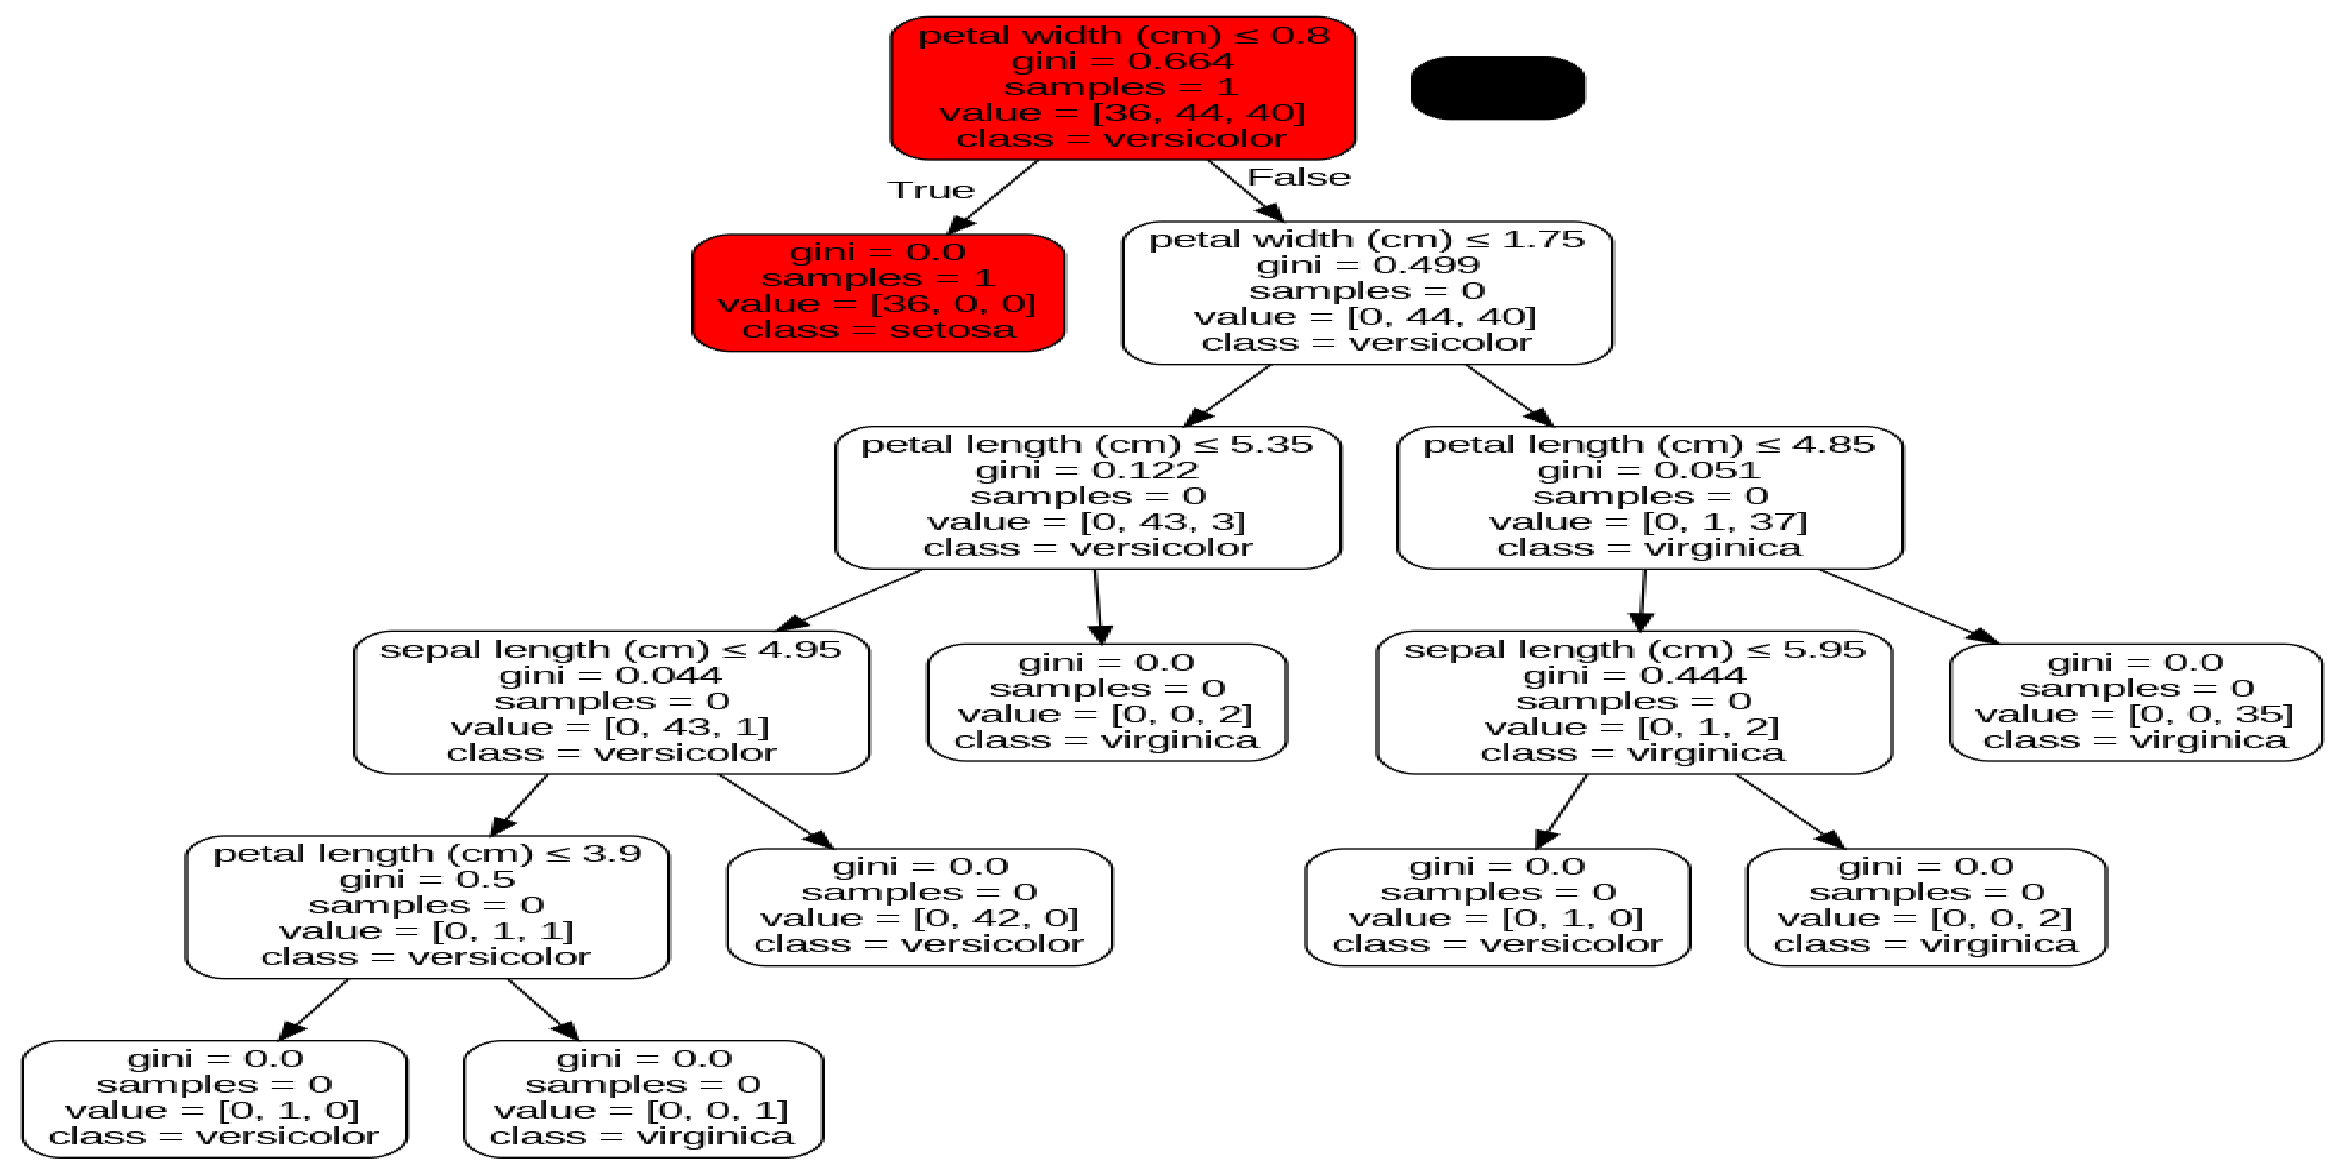

<Figure size 640x480 with 0 Axes>

In [21]:
print(f"Exemple de référence à expliquer {i} : {x}")

plot_path(chemin_decision,i, dt, iris.feature_names, iris.target_names)

## Exercice 2 - Génération de bases d'apprentissage et d'explications

Dans cet exercice, nous allons nous inspirer de l'approche LORE pour générer des explications de classification

### 1. Génération d'une base d'apprentissage pour construire un modèle de substitution



D'après le cours, la base d'apprentissage correspond au voisinage de x dont la classification par notre classifieur couvre les deux classes.


Autrement dit, nous allons :      
1. Générer des exemples proches de x et de même classe
2. Générer des exemples proches de x et de classe différente


Pour ce faire, nous allons suivre les étapes suivantes :      
* Générer des instances perturbées
* Générer le voisinage

Pour les perturbations des données, nous utiliserons la distribution normale car elle permet de modéliser des variations autour de la valeur moyenne, elle est aussi symétrique.

In [22]:
def gen_perturbes(X, n):
    """
    Générer un ensemble de données perturbées à partir d'une matrice.

    Paramètres :
    - X : Matrice d'entrée d'origine.
    - n : Nombre d'échantillons perturbés à générer pour chaque élément de la matrice.

    Renvoie :
    - data_perturbed : Ensemble de données perturbées avec la même forme que X.
    """
    data_perturbed = []

    for i in range(X.shape[1]):
        values = X[:,i]
        mu = np.mean(values)
        std = np.std(values)

        perturbations = np.random.normal(mu, std, n)

        data_perturbed.append(perturbations)

    data_perturbed = np.column_stack(data_perturbed)
    data_perturbed = np.concatenate((X, data_perturbed), axis=0)

    return np.array(data_perturbed)


In [23]:
n = 1000
X1 = gen_perturbes(X_test,n)

In [24]:
X_test.shape

(30, 4)

In [25]:
X1.shape

(1030, 4)

In [26]:
X1

array([[ 4.4       ,  3.2       ,  1.3       ,  0.2       ],
       [ 5.        ,  3.3       ,  1.4       ,  0.2       ],
       [ 5.4       ,  3.9       ,  1.7       ,  0.4       ],
       ...,
       [ 6.02821687,  3.42400358,  0.73957994,  0.78836025],
       [ 6.54872137,  3.31691039,  2.44810794,  1.03788454],
       [ 6.41988916,  3.13324991,  2.48179252, -0.01768436]])

Nous allons ensuite, générer le voisinage pour notre instance x

In [27]:
#commençons par apprendre un classifieur boite noire f
#Pour ce faire, nous choisissons un SVM
clf = SVC(kernel= 'rbf', C= 1.0)
clf.fit(X_train, y_train)
print("Prediction modele boite noire ",clf.predict(x.reshape(1, -1)))
print(f"Accuracy {accuracy_score(y_test,clf.predict(X_test))*100} %")

Prediction modele boite noire  [0]
Accuracy 93.33333333333333 %


In [28]:
def generer_base_apprent(X, clf, n=1000):

  #Générer perturbations

  X_pert = gen_perturbes(X,n)

  # Prédit l'étiquette de l'instance x
  y_pred = clf.predict(X_pert)

  # Crée une matrice yX en concaténant la prédiction avec l'instance x originale
  yX = np.concatenate((y_pred.reshape(-1, 1), X_pert), axis=1)

  # Initialise une liste data contenant les colonnes de la matrice yX
  data = [yX[:, i] for i in range(yX.shape[1])]

  # Réorganise la liste data pour obtenir une matrice où chaque colonne représente une caractéristique
  data = np.column_stack(data)

  return data, X_pert, y_pred

In [29]:
data, X_app, y_app = generer_base_apprent(X_test, clf, n=1000)

In [30]:
X_app

array([[ 4.4       ,  3.2       ,  1.3       ,  0.2       ],
       [ 5.        ,  3.3       ,  1.4       ,  0.2       ],
       [ 5.4       ,  3.9       ,  1.7       ,  0.4       ],
       ...,
       [ 6.07203127,  3.58376361,  6.44123522,  1.26889395],
       [ 6.24940976,  1.72182666,  2.09563834,  0.14169694],
       [ 5.53175052,  2.67520267,  2.62616382, -0.92579792]])

In [31]:
y_app

array([0, 0, 0, ..., 2, 0, 0])

In [32]:
data #Nouvelle base d'apprentissage avec label + données

array([[ 0.        ,  4.4       ,  3.2       ,  1.3       ,  0.2       ],
       [ 0.        ,  5.        ,  3.3       ,  1.4       ,  0.2       ],
       [ 0.        ,  5.4       ,  3.9       ,  1.7       ,  0.4       ],
       ...,
       [ 2.        ,  6.07203127,  3.58376361,  6.44123522,  1.26889395],
       [ 0.        ,  6.24940976,  1.72182666,  2.09563834,  0.14169694],
       [ 0.        ,  5.53175052,  2.67520267,  2.62616382, -0.92579792]])

### 2. Génération de l'explication pour les exemples de la base de test

In [33]:
def explication(i, X_test, g,f, n=100,feature_names = iris.feature_names,target_names = iris.target_names):
  #L'exemple de référence
  x = X_test[i]

  #Génération de la nouvelle base d'apprentissage
  data, X_app, y_app = generer_base_apprent(X_test, f,n)

  #Explication par g : arbre de décision (comme mentionné en cours)
  g.fit(X_app,y_app)

  y_hat = g.predict(x.reshape(1,-1))

  y_hat_boite_noire = f.predict(x.reshape(1,-1))

  print("Règles de décision :")
  print()
  expl(X_test,i)
  print()
  print("-------------------")
  print()
  cf_r, nr = cf_rules(dt,feature_names,target_names, nodes_visited)
  print(f"Règles contrefactuelles r' : ")
  for r in cf_r :
    print(r)
  print()
  print(f"Nombre de tests invalidés pour l'exemple d'observation {i} est : {nr}")


In [34]:
explication(i, X_test, dt, clf, n=100)

Règles de décision :

Rules used to predict sample 15:

decision node 0 : (X_test[15, 2] = 1.7) <= 2.501879334449768)
decision node 1 : (X_test[15, 1] = 3.8) > 2.519801616668701)

-------------------

Règles contrefactuelles r' : 
if (('petal length (cm)', 0) > 2.502) and (('petal length (cm)', 12) <= 5.579) and (('petal width (cm)', 13) <= 1.777) and (('petal length (cm)', 14) > 2.708) and (('sepal width (cm)', 18) <= 3.737) then class: versicolor (proba: 100.0%)
if (('petal length (cm)', 0) > 2.502) and (('petal length (cm)', 12) > 5.579) and (('petal width (cm)', 28) > 0.182) then class: virginica (proba: 100.0%)
if (('petal length (cm)', 0) > 2.502) and (('petal length (cm)', 12) <= 5.579) and (('petal width (cm)', 13) > 1.777) and (('petal length (cm)', 23) > 4.652) then class: virginica (proba: 100.0%)
if (('petal length (cm)', 0) > 2.502) and (('petal length (cm)', 12) <= 5.579) and (('petal width (cm)', 13) > 1.777) and (('petal length (cm)', 23) <= 4.652) and (('petal width (c

## Exercice 3 - Expérimentations

Dans cet exercice, nous allons expérimenter notre programme sur 2 bases d'exemples de complexité variable :      

1. Nombre d'attributs grand => breast cancer

2. Classes déséquilibrées => wine

### 1. Breast cancer

In [44]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
df = pd.DataFrame(bc.data, columns=bc.feature_names)
df['target'] = bc.target
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [45]:
bc.data.shape

(569, 30)

On voit bien qu'on passe de 4 attributs à 30 dans ce cas

In [46]:
#Séparer en base de test et d'apprentissage
X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, test_size = 0.2)

Accuracy score : 93.85964912280701 %


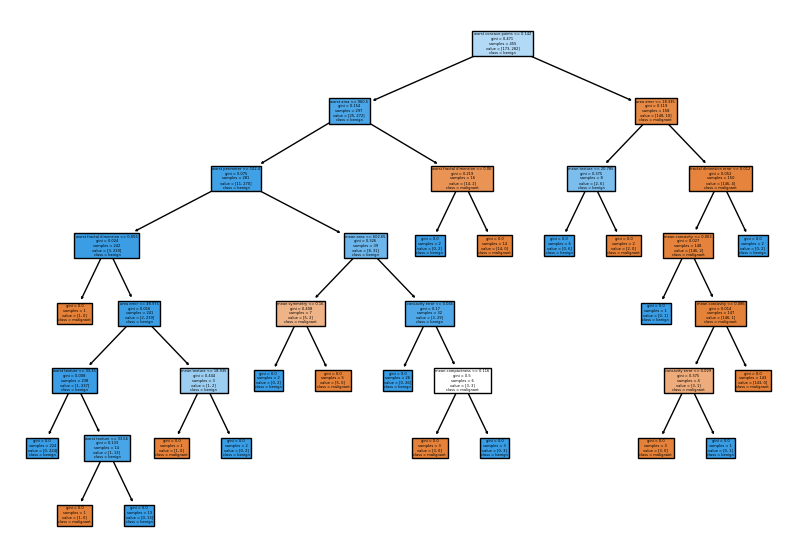

In [48]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(f"Accuracy score : {accuracy_score(y_test,dt.predict(X_test))*100} %")
fig = plt.figure(figsize = (10,7))
tree.plot_tree(dt, feature_names=bc.feature_names, class_names = bc.target_names, filled = True)
plt.show()

#### Génération explication

chemin de decision pour l'instance numero  10
Rules used to predict sample 10:

decision node 0 : (X_test[10, 27] = 0.0) <= 0.1423499956727028)
decision node 1 : (X_test[10, 23] = 558.9) <= 960.5)
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


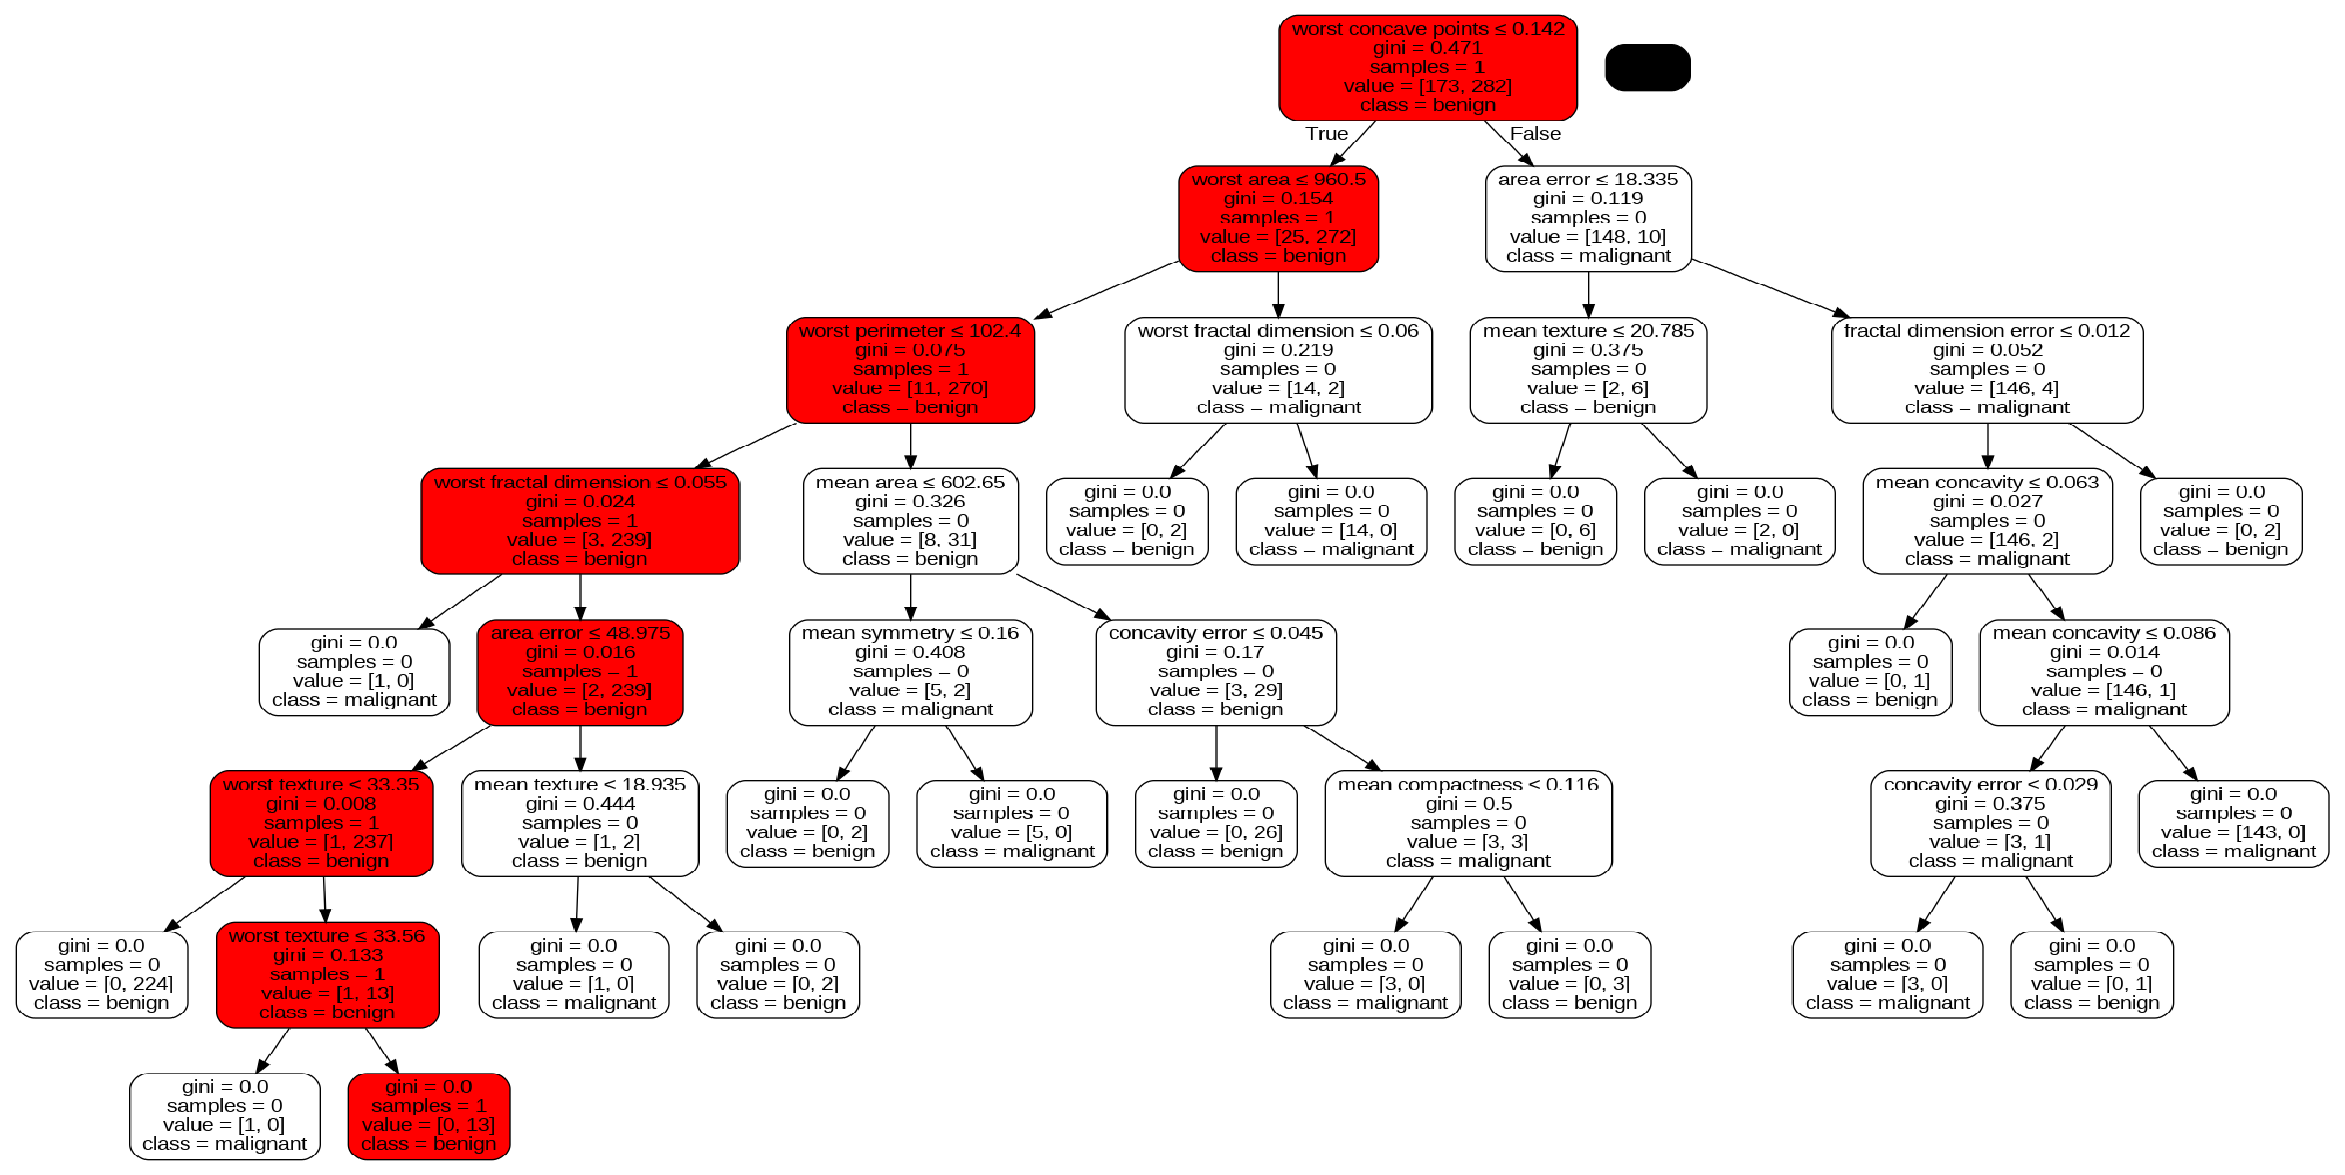

<Figure size 640x480 with 0 Axes>

In [49]:
i = 10
x = X_test[i]
print("chemin de decision pour l'instance numero ",i)
dt.predict(x.reshape(1,-1))

#Regle de decision
decision_paths = dt.decision_path(x.reshape(1,-1))
expl(X_test,i)


plot_path(decision_paths,i,dt,bc.feature_names, bc.target_names)


#### Génération règles contrefactuelles

In [50]:
nodes_visited = nodes_seen(decision_paths, dt, bc.target_names)

print(f"Liste des nœuds visités par l'arbre pour l'exemple {i} : {nodes_visited}")

class :  benign
Liste des nœuds visités par l'arbre pour l'exemple 10 : ([0, 1, 2, 3, 5, 6, 8, 10], 'benign')


In [51]:
cf_r, nr = cf_rules(dt, bc.feature_names, bc.target_names, nodes_visited)

print(f"Règles contrefactuelles r' : ")
for r in cf_r :
  print(r)

print()
print(f"Nombre de tests invalidés pour l'exemple d'observation {i} est : {nr}")


Règles contrefactuelles r' : 
if (('worst concave points', 0) > 0.142) and (('area error', 26) > 18.335) and (('fractal dimension error', 30) <= 0.012) and (('mean concavity', 31) > 0.063) and (('mean concavity', 33) > 0.086) then class: malignant (proba: 100.0%)
if (('worst concave points', 0) <= 0.142) and (('worst area', 1) > 960.5) and (('worst fractal dimension', 23) > 0.06) then class: malignant (proba: 100.0%)
if (('worst concave points', 0) <= 0.142) and (('worst area', 1) <= 960.5) and (('worst perimeter', 2) > 102.4) and (('mean area', 14) <= 602.65) and (('mean symmetry', 15) > 0.16) then class: malignant (proba: 100.0%)
if (('worst concave points', 0) <= 0.142) and (('worst area', 1) <= 960.5) and (('worst perimeter', 2) > 102.4) and (('mean area', 14) > 602.65) and (('concavity error', 18) > 0.045) and (('mean compactness', 20) <= 0.116) then class: malignant (proba: 100.0%)
if (('worst concave points', 0) > 0.142) and (('area error', 26) > 18.335) and (('fractal dimension

#### Générer explication - approche LORE

In [52]:
clf = SVC(kernel= 'rbf', C= 1.0)
clf.fit(X_train, y_train)
print("Prediction modele boite noire ",clf.predict(x.reshape(1, -1)))
print(f"Accuracy {accuracy_score(y_test,clf.predict(X_test))*100} %")

Prediction modele boite noire  [1]
Accuracy 91.22807017543859 %


In [53]:
explication(i, X_test, dt, clf, n=100,feature_names = bc.feature_names,target_names = bc.target_names)

Règles de décision :

Rules used to predict sample 10:

decision node 0 : (X_test[10, 23] = 558.9) <= 941.3518371582031)
decision node 1 : (X_test[10, 3] = 465.4) > 14.981943130493164)

-------------------

Règles contrefactuelles r' : 
if (('worst area', 0) > 941.352) then class: malignant (proba: 100.0%)
if (('worst area', 0) <= 941.352) and (('mean area', 1) <= 14.982) and (('perimeter error', 2) > 1.844) then class: malignant (proba: 100.0%)

Nombre de tests invalidés pour l'exemple d'observation 10 est : 2


Nous pouvons constater que la complexité du jeu de données, caractérisée par le grand nombre d'attributs, peut rendre l'explication moins évidente. Cependant, pour cet exemple spécifique, nous pouvons déduire que si la valeur de l'attribut "worst area" était supérieure à 941.352, alors l'instance serait classée comme maligne.

### Wine

In [55]:
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


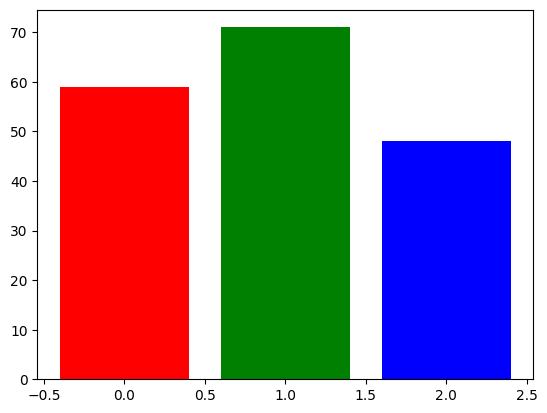

In [58]:
val, nbr= np.unique(wine.target,return_counts=True)
plt.bar(val, nbr, color = ['red','green','blue'])
plt.show()

On voit bien qu'il y a un déséquilibre de classes

Accuracy score : 88.88888888888889 %


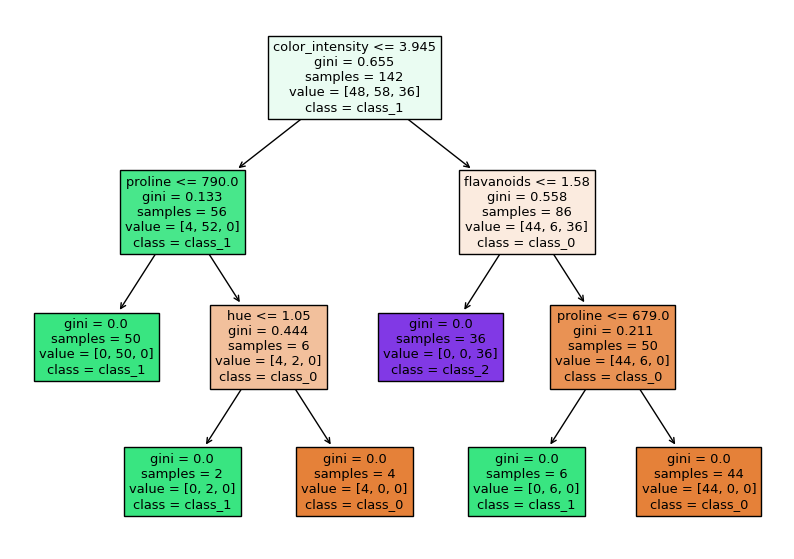

In [59]:
#Séparer en base de test et d'apprentissage
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size = 0.2)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(f"Accuracy score : {accuracy_score(y_test,dt.predict(X_test))*100} %")
fig = plt.figure(figsize = (10,7))
tree.plot_tree(dt, feature_names=wine.feature_names, class_names = wine.target_names, filled = True)
plt.show()

#### Génération explication

chemin de decision pour l'instance numero  10
Rules used to predict sample 10:

decision node 0 : (X_test[10, 9] = 2.5) <= 3.9450000524520874)
decision node 1 : (X_test[10, 12] = 625.0) <= 790.0)
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


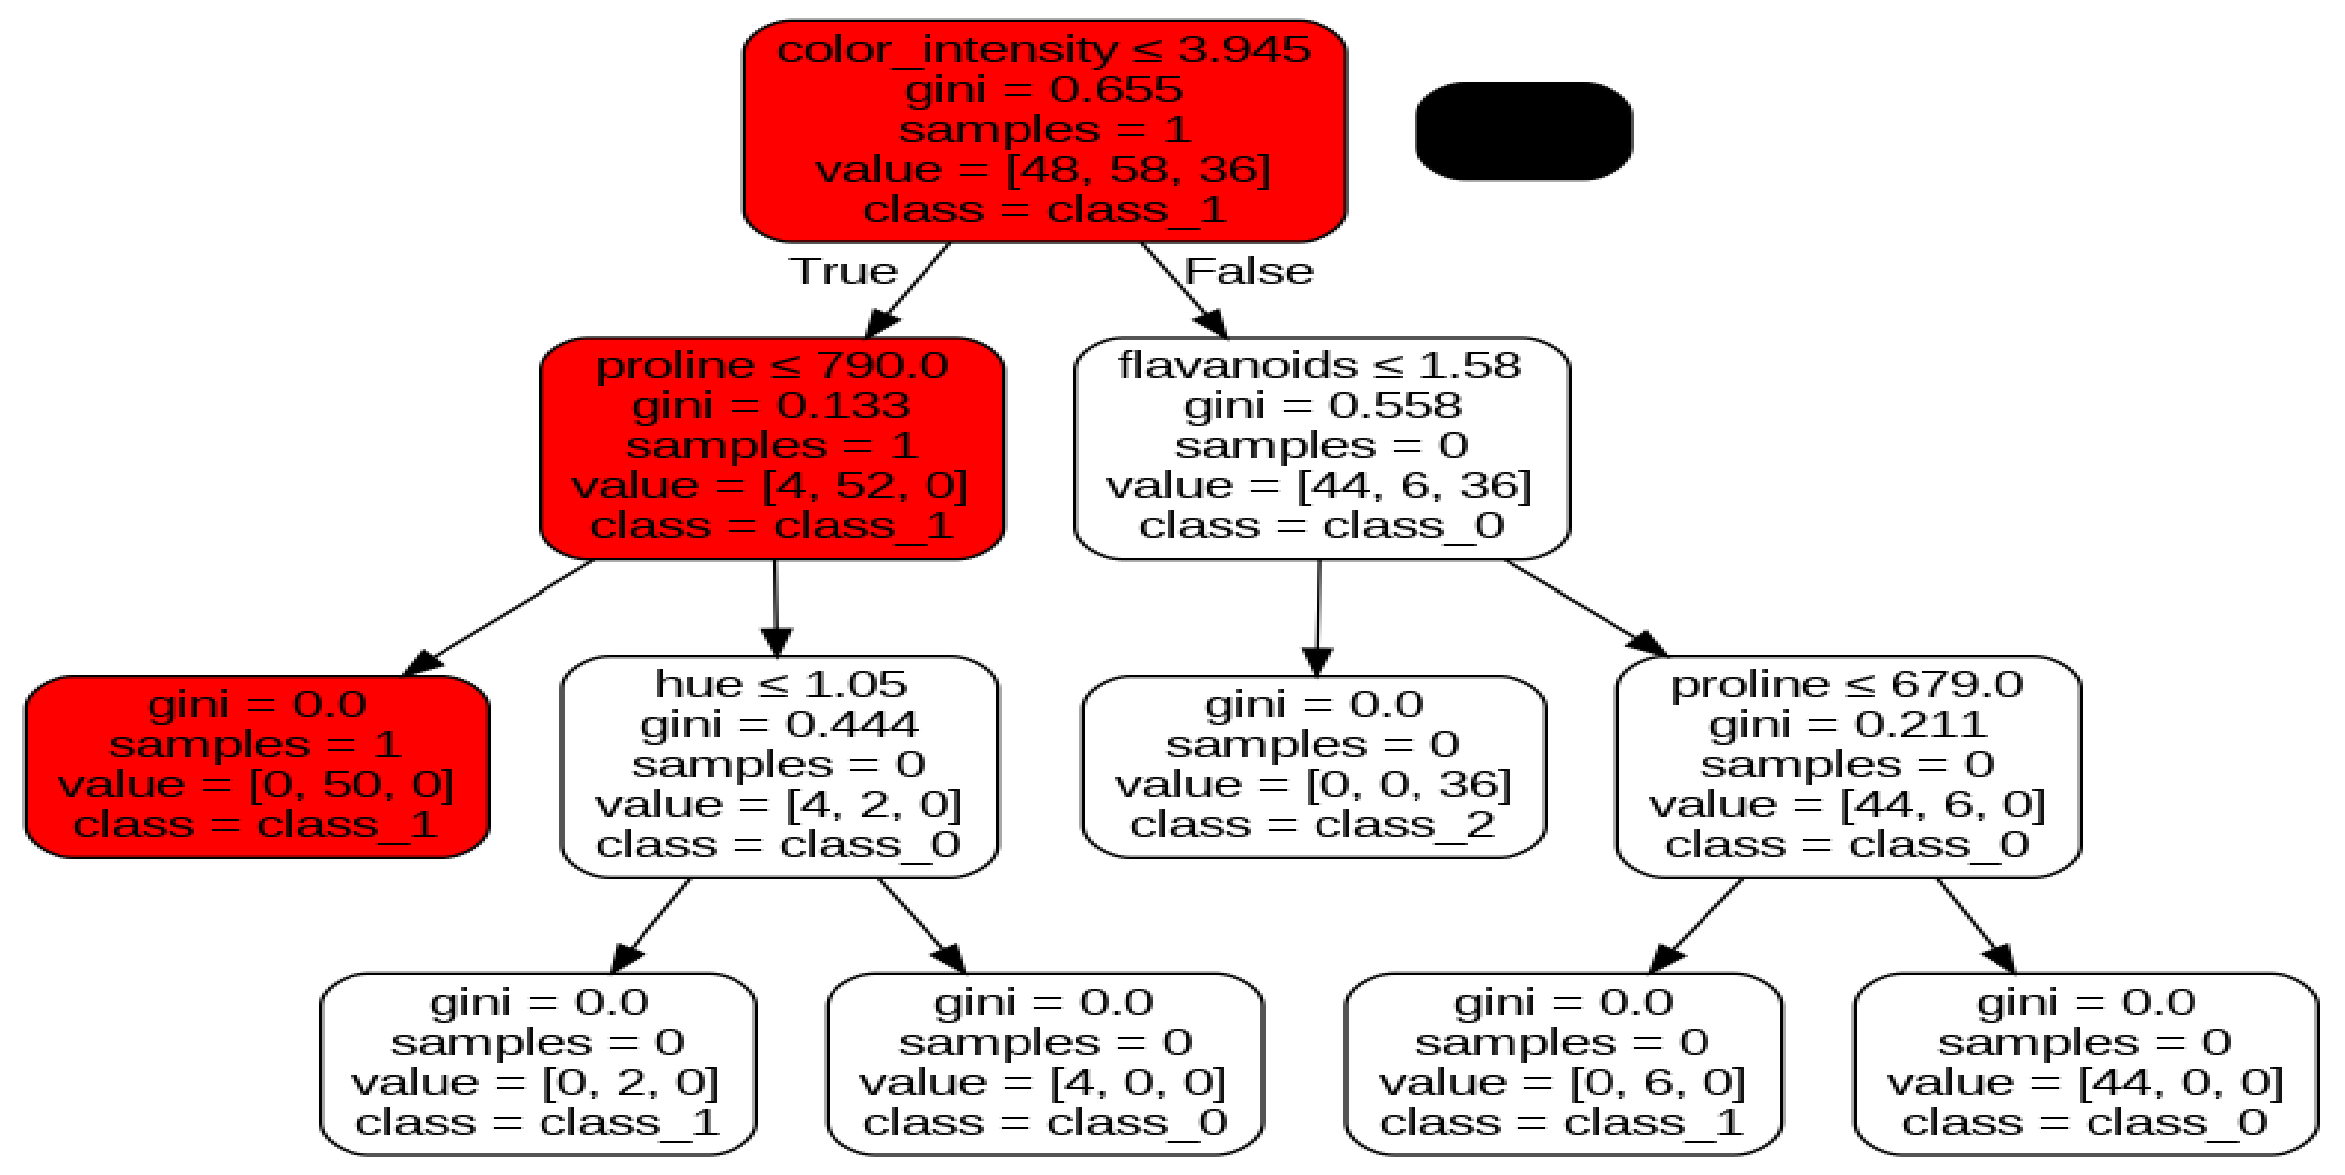

<Figure size 640x480 with 0 Axes>

In [60]:
i = 10
x = X_test[i]
print("chemin de decision pour l'instance numero ",i)
dt.predict(x.reshape(1,-1))

#Regle de decision
decision_paths = dt.decision_path(x.reshape(1,-1))
expl(X_test,i)


plot_path(decision_paths,i,dt,wine.feature_names, wine.target_names)


#### Génération règles contrefactuelles

In [61]:
nodes_visited = nodes_seen(decision_paths, dt, wine.target_names)

print(f"Liste des nœuds visités par l'arbre pour l'exemple {i} : {nodes_visited}")

class :  class_1
Liste des nœuds visités par l'arbre pour l'exemple 10 : ([0, 1, 2], 'class_1')


In [62]:
cf_r, nr = cf_rules(dt, wine.feature_names, wine.target_names, nodes_visited)

print(f"Règles contrefactuelles r' : ")
for r in cf_r :
  print(r)

print()
print(f"Nombre de tests invalidés pour l'exemple d'observation {i} est : {nr}")


Règles contrefactuelles r' : 
if (('color_intensity', 0) > 3.945) and (('flavanoids', 6) > 1.58) and (('proline', 8) > 679.0) then class: class_0 (proba: 100.0%)
if (('color_intensity', 0) > 3.945) and (('flavanoids', 6) <= 1.58) then class: class_2 (proba: 100.0%)
if (('color_intensity', 0) <= 3.945) and (('proline', 1) > 790.0) and (('hue', 3) > 1.05) then class: class_0 (proba: 100.0%)

Nombre de tests invalidés pour l'exemple d'observation 10 est : 3


#### Générer explication - approche LORE

In [63]:
clf = SVC(kernel= 'rbf', C= 1.0)
clf.fit(X_train, y_train)
print("Prediction modele boite noire ",clf.predict(x.reshape(1, -1)))
print(f"Accuracy {accuracy_score(y_test,clf.predict(X_test))*100} %")

Prediction modele boite noire  [1]
Accuracy 58.333333333333336 %


In [64]:
explication(i, X_test, dt, clf, n=100,feature_names = wine.feature_names,target_names = wine.target_names)

Règles de décision :

Rules used to predict sample 10:

decision node 0 : (X_test[10, 12] = 625.0) <= 833.9569091796875)
decision node 1 : (X_test[10, 12] = 625.0) <= 643.5701599121094)

-------------------

Règles contrefactuelles r' : 
if (('proline', 0) > 833.957) then class: class_0 (proba: 100.0%)
if (('proline', 0) <= 833.957) and (('proline', 1) > 643.57) then class: class_2 (proba: 100.0%)

Nombre de tests invalidés pour l'exemple d'observation 10 est : 2


Une interprétation basée sur l'arbre de décision pourrait expliquer que l'instance n'a pas été classée dans la classe 0, car la caractéristique "proline" n'est pas supérieure à 833.957.

En ce qui concerne le déséquilibre, il est notable que l'arbre de décision a relativement peu de règles pour prédire la classe 2. Ce déséquilibre peut représenter un défi, notamment lors de la construction d'un modèle de substitution, car le modèle pourrait être moins précis pour la classe sous-représentée.

## Conclusion

Dans ce TME, nous avons généré le chemin des règles de prédiction pour une instance, que ce soit pour une base de données simple telle que iris ou des bases plus complexes avec un nombre d'attributs, tel que breast cancer, ou encore sur un jeu de données déséquilibrés à l'image de la base wine.

En effet, en utilisant un classifieur de type boîte noire, comme SVM avec noyau 'rbf', et une instance à expliquer x, nous avons d'abord créé un voisinage autour de cette observation de référence. Sur ce voisinage, nous avons entraîné un arbre de décision.

Ensuite, nous avons généré les règles contre-factuelles qui expliquent la prédiction pour cette instance spécifique.